# Finding spectral types

a) Consider the region of 1 deg around Helvetios coordinates and store their spectral types

b) Find the different spectral types that exist in this region 



## Hints:
- Remember Class 2

In [2]:
from astroquery.simbad import Simbad
import astropy.units as u

# define custom Simbad query
customSimbad = Simbad()

# Add VoTable fields to custom query Simbad
customSimbad.add_votable_fields('sptype','flux(V)')


# query for region of 1 deg around Helvetios coordinates
region_table = customSimbad.query_region("Helvetios", radius=1. * u.deg)


available_types = set(region_table['SP_TYPE'])

print("We found the following spectral types: {}".format(available_types))

We found the following spectral types: {'', 'DQ', 'G0', 'K2V', 'G5V', 'F5', 'DA', 'K7', 'F0', 'G6V', 'F7V', 'K2', 'G2V', 'DA:', 'G5', 'sdA', 'L2.5', 'F2', 'K1V', 'K0', 'K5', 'F8V', 'G8V', 'K0V', 'F9V', 'SNIa', 'G9V', 'K3V', 'G7V', 'G3V', 'A9/F3', 'G2IV', 'R?', 'F8', 'D', 'G1V', 'K7V'}


# Median filter

In the previous classes we have implemented the median filter using "pure" Python and a scientific library.

The goals, for this Class are:

a) To re-implement the algorithm paralelly, using Python's multiprocessing library. 

        a-1) Using pure Python to compute the median filter 

        a-2) Using the median filter of scipy 

    
b) Apply it to the HARPS spectra that was previously given

c) Plot the evolution of computational time with the number of processes



## Hints:

- It might be better to use the divide the orders as 'tasks'

In [3]:
"""
Pure Python median filter (same from the first class; Copied here for )
"""
from statistics import median 

def boundary_condition(y_data, index, which, filter_size):
    """
    Applies the selected boundary condition to the y_data 

    Parameters
    ============
    y_data : list 
        The input data 
    index : int
        Index of the leftmost edge of the filter
    which : str 
        Which boundary condition to apply. Options : ['mirror']
    filter_size : int
        Number of points in the median window

    Returns 
    ===========
    new_values : list
        Values that expand the input data to be able to apply the filter 
    """
    if which == 'mirror':
        if index < 0:
            return y_data[1 : abs(index)+1]
        elif index > len(y_data) - filter_size: 
            return y_data[-(index + filter_size - len(y_data)+1) : -1 ]

def python_filter(y_data, filter_size):
    """
    Calculation of the median filter using a sliding window centered in each point. The filter size must be odd, in order to        guarantee that there is the        same number of points being sampled in each side.


    Parameters
    ============
    y_data : list 
        The input data 
    filter_size : int 
        Number of points in the median window

    Returns 
    ===========
    filtered_values : list
        Computed median filter 
    """
    y_data = y_data.tolist()
    if filter_size % 2 == 0:
        raise ValueError("Filter size should be odd")
    output = []
    data_size = len(y_data)

    initial_leftmost_edge = -int(filter_size/2)
    
    # start_index is the position of the leftmost edge of the filter
    for start_index in range(initial_leftmost_edge, data_size + initial_leftmost_edge):
        
        if start_index < 0:
            # the leftmost edge is outside the y_data array
            value = median(y_data[0:  filter_size - abs(start_index)] + boundary_condition(y_data, start_index, 'mirror', filter_size=filter_size))
        elif start_index > data_size - filter_size:
            # the rightmost edge is outside the y_data array
            value = median(y_data[start_index:] + boundary_condition(y_data, start_index, 'mirror', filter_size=filter_size))
        else:
            value = median(y_data[start_index : start_index+filter_size])
        output.append(value)

    return output




In [4]:
"""
Scipy median filter
"""

from scipy.ndimage import median_filter
 
def scipy_filter(y_data, filter_size):
    return median_filter(y_data, filter_size)


In [5]:
"""
Handling multiprocessing
"""
from multiprocessing import shared_memory 
import numpy as np 

def access_buffers(info_tuple):
    existing_shm = shared_memory.SharedMemory(name=info_tuple[0])
    array = np.ndarray(info_tuple[1], dtype=info_tuple[2], buffer=existing_shm.buf) 
    return existing_shm, array 

def close_buffers(buffers, unlink = False):
    for buffer in  buffers:
        buffer.close()
        
        if unlink:
            buffer.unlink()


In [6]:
"""
Loading the data and preparing shared memory arrays
"""
from multiprocessing import shared_memory
from astropy.io import fits 
import numpy as np 

def load_input_data(data_path):
    """
    LOad data from disk
    """
    with fits.open(data_path) as hdulist:
        wavelengths = hdulist[1].data
        spectra = hdulist[2].data 

    return wavelengths, spectra 

def setup_shared_mem_array(array):
    """
    Standardized method to create shared memory numpy arrays
    """
    shm = shared_memory.SharedMemory(create=True, size=array.nbytes)
    b = np.ndarray(array.shape, dtype=array.dtype, buffer=shm.buf)
    b[:] = array[:]  
    return shm, (shm.name, b.shape, b.dtype)


def open_buffers(data_path):
    """
    Load data from disk and setup shared memory arrays
    """
    buffer_dict = {}
    wavelengths, spectra = load_input_data(data_path)
    outputs = np.zeros_like(spectra)
    
    buffer_list = []

    for index, data in enumerate([outputs, spectra]):
        keyword = 'output' if index == 0 else 'spectra'
        buff, buffer_dict[keyword] = setup_shared_mem_array(data)
        buffer_list.append(buff)
    return buffer_list, buffer_dict

In [7]:
"""
Application of the filters - workers
"""

def worker(target_function, buffer_dictionary, order_list):
    """
    Load numpy array from the shared memory buffer and apply the given target function

    Parameters
    ==========
    target_function : function
        Function to be evaluated
    buffer_dictionary: dict
        As created by the open_buffers function
    order_list : list
        Orders that this worker will process
    """
    shared_buffers = [] 
    buff, spectra = access_buffers(buffer_dictionary['spectra'])
    shared_buffers.append(buff)
    buff, output_array = access_buffers(buffer_dictionary['output'])
    shared_buffers.append(buff)
    try:
        for order in order_list:
            filtered_data = target_function(spectra[order], 1001)
            output_array[order][:] = filtered_data
    
    except Exception as e:
        print(e)
        close_buffers(shared_buffers)
    



Starting 1 cores
Starting 3 cores
Starting 5 cores
Starting 7 cores


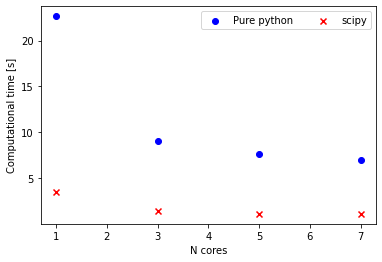

In [8]:
import time
import numpy as np 
from multiprocessing import Pool 

from functools import partial
import matplotlib.pyplot as plt 

target_functions = {'Pure python' : python_filter,
                    'scipy' : scipy_filter
                    }

# Will run the median filter using the number of cores inside the list
core_list = range(1,8,2)
buffer_list, buffer_dictionary = open_buffers(data_path='../data/spectra.fits')
N_orders = 72
for N_cores in core_list:
    print("Starting {} cores".format(N_cores))
    for name, function in target_functions.items():
        t_start = time.time() 

        # We can pass multiple arguments to the .map function by following:
        # https://stackoverflow.com/questions/25553919/passing-multiple-parameters-to-pool-map-function-in-python

        iterable = partial(worker, function, buffer_dictionary)
        
        # Dividing the orders into equaly-sized blocks
        tasks = np.array_split(range(N_orders), N_cores)

        with Pool(N_cores) as p:
            p.map(iterable, tasks)

        t_end = time.time() - t_start               


        color = 'red' if name == 'scipy' else 'blue'
        marker = 'x' if name == 'scipy' else 'o'
        label = name if N_cores == 1 else None
        plt.scatter(N_cores, t_end, color = color, marker = marker, label = label)

close_buffers(buffer_list, unlink=True)
plt.legend(ncol=2)
plt.ylabel("Computational time [s]")
plt.xlabel("N cores")
plt.show()
